In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import linear_model, ensemble
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style='whitegrid', font_scale=1.3)

In [2]:
#set seaborn plot display options
sns.set(style='whitegrid', palette='muted', font_scale=1.3)

#color variables incase they're needed
color_b = sns.color_palette('muted').as_hex()[0]
color_g = sns.color_palette('muted').as_hex()[1]
color_r = sns.color_palette('muted').as_hex()[2]
color_p = sns.color_palette('muted').as_hex()[3]
color_y = sns.color_palette('muted').as_hex()[4]
color_c = sns.color_palette('muted').as_hex()[5]

# ¡ Change intro to reflect new project !

# 0. Introduction

## 0.1 Research Proposal
- __Research Question:__ Can we use residential property sales data to predict the financial crisis$^1$ (& the recovery)?
- Why is this a good question to study?
- What are some challenges to this question?
- *fill in with some more recession info, any relevent details that come up and have nowhere else to go, etc*

$^1$ Using NBER dates for great recession: Dec 2007 - June 2009 [source](https://www.nber.org/cycles.html)

## 0.2 Method
1. Develop a model to predict saleprice; will also establish a level of predictive power to compare with later
2. Apply and train only using pre-crisis data
3. Test on crisis data, goal being to predict the recession (& later the recovery)m

# 1. Dataset: Ames, Iowa Housing Market Data

## 1.1 Dataset background

__Abstract Excerpt:__

This paper presents a data set describing the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values.

__Full Description:__

https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

__Data Source:__

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

Kaggle API: >_ kaggle competitions download -c house-prices-advanced-regression-techniques

## 1.2 Upload Data

In [3]:
train_raw = pd.read_csv('train.csv')
#train_raw.head()

In [4]:
#train_raw.describe()

In [5]:
#train_raw.columns

## 2.1 Basic Cleaning

In [6]:
#set df to manipulate, leave raws accessible
train = train_raw.copy()

#lowercase column names
train.columns = [x.lower() for x in train.columns]

#strip whitespace
to_strip = train.select_dtypes(include='object')
train[to_strip.columns] = to_strip.apply(lambda x: x.str.strip())

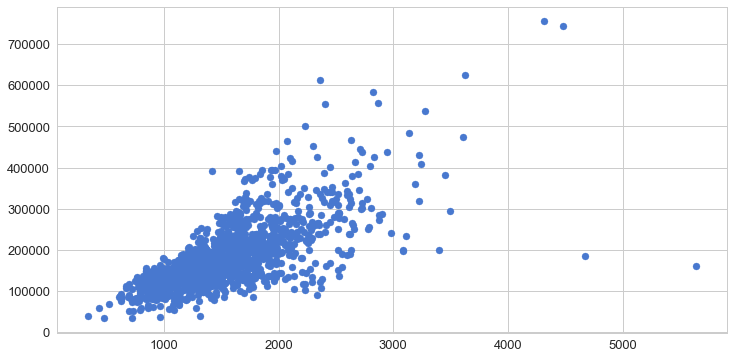

In [7]:
plt.figure(figsize=(12,6))
plt.scatter(train['grlivarea'], train['saleprice'])
plt.show()

In [8]:
train = train[train.grlivarea < 4000]
print(train.grlivarea.max())

3627


## 2.3 Missingness

In [9]:
#see whats missing
missing_data = train.isnull().sum().sort_values(ascending=False)
missing_data = missing_data.reset_index()
missing_data.columns = ['variable','rows_missing']
missing_data = missing_data[missing_data['rows_missing'] > 0]
missing_data

,variable,rows_missing
0,poolqc,1451
1,miscfeature,1402
2,alley,1365
3,fence,1176
4,fireplacequ,690
5,lotfrontage,259
6,garagecond,81
7,garagetype,81
8,garageyrblt,81
9,garagefinish,81


__NA indicates lack of feature:__ impute no_feature or 0 (descriptions are available in the 'data_description.txt' file)
- poolqc: pool quality
- miscfeature: miscellaneous feature not covered in other categories
- alley: type of alley access to property
- fence: fence quality
- fireplacequ: fireplace quality
- garagecond: garage condition
- garagetype: garage location
- garageyrblt: year garage was built
- garagefinish: interior finish of garage
- garagequal: garage quality
- bsmtexposure: refers to walkout or garden level walls
- bsmtfintype1: rating of basement finished area
- bsmtfintype2: rating of basement finished area (if multiple types)
- bsmtcond: evaluates the general condition of the basement
- bsmtqual: evaluates the height of the basement (in inches, Excellent >= 100, Poor < 70)
- masvnrtype: masonry veneer type
- masvnrarea: masonry veneer area in square feet

In [10]:
#handle missing values, easy part
train['poolqc'].fillna('no_pool', inplace=True)
train['miscfeature'].fillna('no_miscfeat', inplace=True)
train['alley'].fillna('no_access', inplace=True)
train['fence'].fillna('no_fence', inplace=True)
train['fireplacequ'].fillna('no_fireplace', inplace=True)
train['garagecond'].fillna('no_garage', inplace=True)
train['garagetype'].fillna('no_garage', inplace=True)
train['garagefinish'].fillna('no_garage', inplace=True)
train['garagequal'].fillna('no_garage', inplace=True)
train['garageyrblt'].fillna(0, inplace=True)
train['bsmtexposure'].fillna('no_bsmt', inplace=True)
train['bsmtfintype1'].fillna('no_bsmt', inplace=True)
train['bsmtfintype2'].fillna('no_bsmt', inplace=True)
train['bsmtcond'].fillna('no_bsmt', inplace=True)
train['bsmtqual'].fillna('no_bsmt', inplace=True)
train['masvnrtype'].fillna('no_masvnr', inplace=True)
train['masvnrarea'].fillna(0, inplace=True)

#### Special Case 1

electrical: electrical system, can be one of the following
- SBrkr: Standard Circuit Breakers & Romex
- FuseA: Fuse Box over 60 AMP and all Romex wiring (Average)	
- FuseF: 60 AMP Fuse Box and mostly Romex wiring (Fair)
- FuseP: 60 AMP Fuse Box and mostly knob elect & tube wiring (poor)
- Mix: Mixed

In [11]:
print(train['electrical'].value_counts(dropna=False))

SBrkr    1330
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: electrical, dtype: int64


In [12]:
#impute with most common value
train['electrical'].fillna('SBrkr', inplace=True)
print(train['electrical'].value_counts(dropna=False))

SBrkr    1331
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: electrical, dtype: int64


#### Special Case 2
lotfrontage: linear feet of street connected to property, 

In [13]:
print(train['lotfrontage'].value_counts(
    dropna=False).sort_values(ascending=False).head())

NaN      259
 60.0    143
 70.0     70
 80.0     69
 50.0     57
Name: lotfrontage, dtype: int64


Hard to believe that 259 residential properties were sold without connecting to a street
- check against street
- check against lotarea
- come up with strategy to impute

In [14]:
print(train['street'].isnull().sum())
print(train['lotarea'].isnull().sum())

0
0


- Variables street and lotarea have no missing values
- lotfrontage nulls should be filled with something
- investigate the relationship between lotfrontage and lotarea

In [15]:
temp_df = train.loc[:, (train.columns).isin(['lotfrontage', 'lotarea'])]
temp_df['ratio'] = temp_df['lotfrontage'] / temp_df['lotarea']

print('ratio mean: %.5f' % temp_df['ratio'].dropna().mean())
print('ratio median: %.5f' % temp_df['ratio'].dropna().median())
print('ratio mode: %.5f' % temp_df['ratio'].dropna().mode())

ratio mean: 0.00791
ratio median: 0.00771
ratio mode: 0.00833


- Mean, median, and mode are all about 0.008
- Impute lotfrontage nulls with their lotarea * mean ratio to estimate lotfrontage

In [16]:
ratio_mean = (train['lotfrontage'] / train['lotarea']).mean()
train['lotfrontage'].fillna(train['lotarea'] * ratio_mean, inplace=True)
train['lotfrontage'].isnull().sum()

0

## 2.4 Target Variable Distribution

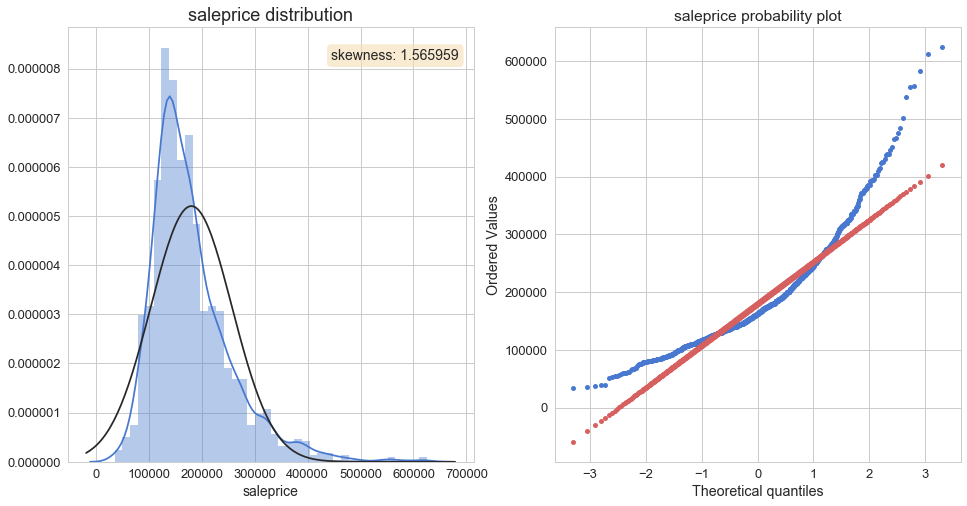

NormaltestResult(statistic=460.3067960010808, pvalue=1.1108342380647651e-100)


In [17]:
plt.figure(figsize=(16,8))

ax1 = plt.subplot(121)
sns.distplot(train['saleprice'], ax=ax1, fit=norm)
ax1.set_xlabel('saleprice', size=14)
ax1.set_title('saleprice distribution', size=18)
#text box
props = dict(boxstyle='round', color='wheat', alpha=.6)
textstr1 = 'skewness: %f' % (train['saleprice'].skew())
ax1.text(0.65, 0.95, textstr1, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax2 = plt.subplot(122)
stats.probplot(train['saleprice'], plot=ax2)
ax2.set_title('saleprice probability plot')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_markerfacecolor(color_b)
ax2.get_lines()[0].set_markersize(10)
ax2.get_lines()[1].set_linewidth(0)
ax2.get_lines()[1].set_marker('.')
ax2.get_lines()[1].set_markerfacecolor(color_r)
ax2.get_lines()[1].set_markersize(10)

plt.show()
print(stats.normaltest(a=train['saleprice']))

- saleprice is pretty far from normally distributed
- See how log transformation looks

In [19]:
print('log:', stats.normaltest(a=np.log(train['saleprice'])))

log: NormaltestResult(statistic=17.417871145375766, pvalue=0.0001651039020773473)


- Log transforming saleprice results in a much more normal distribution

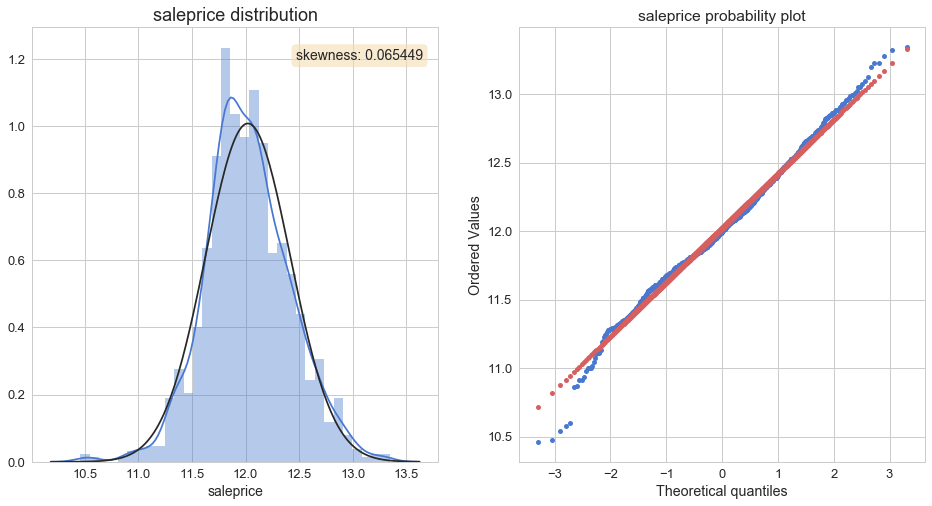

NormaltestResult(statistic=17.417871145375766, pvalue=0.0001651039020773473)


In [20]:
train['saleprice'] = np.log(train['saleprice'])

plt.figure(figsize=(16,8))

ax1 = plt.subplot(121)
sns.distplot(train['saleprice'], ax=ax1, fit=norm)
ax1.set_xlabel('saleprice', size=14)
ax1.set_title('saleprice distribution', size=18)
#text box
props = dict(boxstyle='round', color='wheat', alpha=.6)
textstr1 = 'skewness: %f' % (train['saleprice'].skew())
ax1.text(0.65, 0.95, textstr1, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax2 = plt.subplot(122)
stats.probplot(train['saleprice'], plot=ax2)
ax2.set_title('saleprice probability plot')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_markerfacecolor(color_b)
ax2.get_lines()[0].set_markersize(10)
ax2.get_lines()[1].set_linewidth(0)
ax2.get_lines()[1].set_marker('.')
ax2.get_lines()[1].set_markerfacecolor(color_r)
ax2.get_lines()[1].set_markersize(10)

plt.show()
print(stats.normaltest(a=train['saleprice']))

In [ ]:
train = pd.get_dummies(train)

In [ ]:
X = train.loc[:, ~(train.columns).isin(['saleprice'])]
X = X.drop('id', 1)
y = train['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
lasso = Lasso(alpha=0.0005).fit(X_train, y_train)

cv=10
rmse_train = np.sqrt(-cross_val_score(lasso, X_train, y_train, cv=cv,
                                      scoring='neg_mean_squared_error'))
rmse_test = np.sqrt(-cross_val_score(lasso, X_test, y_test, cv=cv,
                                     scoring='neg_mean_squared_error'))
print('train rmse:', rmse_train.mean())
print('test rmse:', rmse_test.mean())
print('test - train = ', rmse_test.mean() - rmse_train.mean())

In [ ]:
#target distribution
print('un-transformed:', stats.normaltest(a=train['saleprice']))
print('log:', stats.normaltest(a=np.log(train['saleprice'])))
print('log1p:', stats.normaltest(a=np.log1p(train['saleprice'])))

#log1p transform saleprice
train['saleprice'] = np.log1p(train['saleprice'])

#log transform the rest of the numeric variables
features_num = list(train.dtypes[train.dtypes != 'object'].index)

#remove features want to leave alone
features_num.remove('saleprice')
features_num.remove('mosold')
features_num.remove('yrsold')

train[features_num] = np.log1p(train[features_num])

In [ ]:
train = pd.get_dummies(train)

In [ ]:
X = train.loc[:, ~(train.columns).isin(['saleprice'])]
X = X.drop('id', 1)
y = train['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Lasso

In [ ]:
lasso = Lasso(alpha=0.0005).fit(X_train, y_train)

cv=10
rmse_train = np.sqrt(-cross_val_score(lasso, X_train, y_train, cv=cv,
                                      scoring='neg_mean_squared_error'))
rmse_test = np.sqrt(-cross_val_score(lasso, X_test, y_test, cv=cv,
                                     scoring='neg_mean_squared_error'))
print('train rmse:', rmse_train.mean())
print('test rmse:', rmse_test.mean())
print('test - train = ', rmse_test.mean() - rmse_train.mean())

In [ ]:
#from sklearn.decomposition import PCA
#pca = PCA()
#pca.fit(train)
#evr = np.cumsum(pca.explained_variance_ratio_)
#evr = evr[evr < 1]

In [ ]:
#pca = PCA(n_components = len(evr) + 1)
#pca.fit(train)
#train_pca = pca.transform(train)

# Use Lasso for feature engineering

In [ ]:
lasso = LassoCV(alphas=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], cv=10)
lasso.fit(X_train, y_train)

cv = 10
rmse_train = np.sqrt(-cross_val_score(lasso, X_train, y_train, cv=cv,
                                      scoring='neg_mean_squared_error'))
rmse_test = np.sqrt(-cross_val_score(lasso, X_test, y_test, cv=cv,
                                     scoring='neg_mean_squared_error'))
print('alpha:', lasso.alpha_)
print('train rmse:', rmse_train.mean())
print('test rmse:', rmse_test.mean())
print('test - train = ', rmse_test.mean() - rmse_train.mean())

In [ ]:
coefs = pd.Series(lasso.coef_, index=X_train.columns)
print('Lasso selected {} features'.format(sum(coefs != 0)))

### Check lasso's features collinearity

In [ ]:
coefs = coefs[coefs !=0 ]
selected_features = list(coefs.index.values)
df_corr = train[selected_features].corr()
df_corr = df_corr.unstack()
df_corr = pd.DataFrame(df_corr.sort_values(ascending=False))
df_corr = df_corr.reset_index()
df_corr.columns = ['var1', 'var2', 'corr']
df_corr = df_corr[df_corr['corr'] < 1]
df_corr.drop_duplicates(subset='corr', keep='first', inplace=True)
df_corr[df_corr['corr'] >= 0.5]

In [ ]:
#needs some PCA

from sklearn.decomposition import PCA
pca = PCA()

pca.fit(X_train[selected_features])
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)